In [1]:
import sys
sys.path.append("../src")

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import abc
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Generator
import time
import wandb

from dnadb.datasets import Greengenes, Silva
from dnadb import dna, fasta, sample, taxonomy

from deepdna.data.dataset import Dataset
from deepdna.nn.models import load_model
from deepdna.nn.models.dnabert import DnaBertModel, DnaBertPretrainModel
from deepdna.nn import layers, functional, utils
from deepdna.nn.data_generators import SequenceTaxonomyGenerator

In [4]:
tfu.devices.select_gpu(0)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [5]:
api = wandb.Api()

In [7]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-128d-250l:latest").download()
pretrain_model = load_model(path)

wandb: Downloading large artifact dnabert-pretrain-silva-128d-250l:latest, 61.32MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


In [8]:
dnabert_weights = pretrain_model.get_weights()

## Dataset

In [9]:
silva = Dataset(Path("~/work/Datasets/Silva/0").expanduser())

In [10]:
train_fasta_db = sample.load_fasta(next(silva.fasta_dbs(Dataset.Split.Train)))
train_taxonomy_db = taxonomy.TaxonomyDb(next(silva.taxonomy_dbs(Dataset.Split.Train)))

test_fasta_db = sample.load_fasta(next(silva.fasta_dbs(Dataset.Split.Test)))
test_taxonomy_db = taxonomy.TaxonomyDb(next(silva.taxonomy_dbs(Dataset.Split.Test)))

In [11]:
hierarchy = taxonomy.TaxonomyHierarchy.from_dbs([train_taxonomy_db], depth=6)
hierarchy.tokenize("k__Eukaryota; p__Apicomplexa; c__Aconoidasida; o__Haemosporoidia; f__Haemosporoidia; g__Plasmodium")

array([   2,   13,   18,  619,  966, 6024], dtype=int32)

In [12]:
hierarchy.tokenize("k__Eukaryota; p__", pad=True, include_missing=True)

array([3, 0, 0, 0, 0, 0], dtype=int32)

In [133]:
INCLUDE_MISSING = False

In [134]:
train_dataset = SequenceTaxonomyGenerator(
    [(train_fasta_db, train_taxonomy_db)],
    taxonomy_hierarchy=hierarchy,
    labels_as_dict=False,
    sequence_length=250,
    kmer=3,
    # subsample_size=5,
    batches_per_epoch=100,
    batch_size=256,
    include_missing=INCLUDE_MISSING,
    rng=np.random.default_rng(0),
)

test_dataset = SequenceTaxonomyGenerator(
    [(test_fasta_db, test_taxonomy_db)],
    taxonomy_hierarchy=train_dataset.hierarchy,
    labels_as_dict=False,
    sequence_length=250,
    kmer=3,
    # subsample_size=5,
    batches_per_epoch=16,
    batch_size=256,
    include_missing=INCLUDE_MISSING,
    rng=np.random.default_rng(1),
)

In [135]:
# train_dataset[0][1]

In [136]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(train_dataset[0][1][0], tf.random.normal((256, 4)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.8639618>

In [137]:
hierarchy.taxon_counts

(3, 203, 580, 1482, 2405, 8446)

---

## Naive Model (Unnamed Layers)

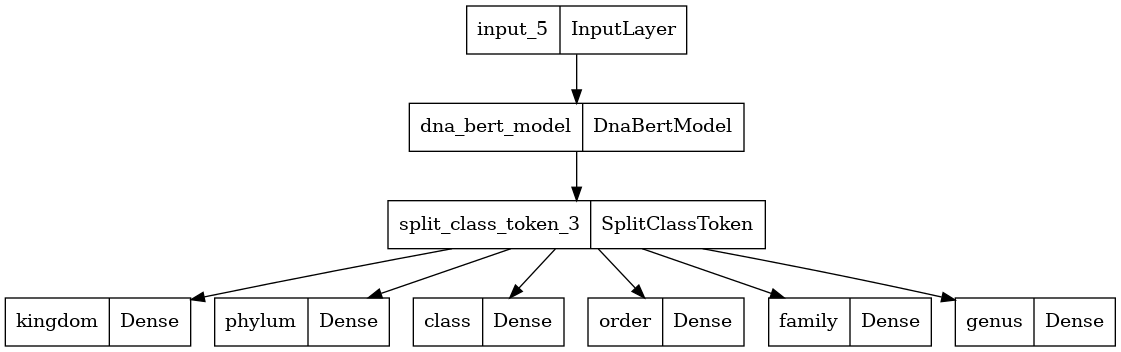

In [138]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
outputs = []
for i in range(hierarchy.depth):
    rank = taxonomy.RANKS[i]
    output = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + 1, name=rank.lower())(y)
    outputs.append(output)
model = tf.keras.Model(x, outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [19]:
history_naive_unnamed = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

Epoch 1/100
100/100 [==============================] - 73s 676ms/step - loss: 30.2738 - kingdom_loss: 0.7475 - phylum_loss: 4.3098 - class_loss: 4.6597 - order_loss: 6.2830 - family_loss: 6.7318 - genus_loss: 7.5421 - kingdom_sparse_categorical_accuracy: 0.8858 - phylum_sparse_categorical_accuracy: 0.3137 - class_sparse_categorical_accuracy: 0.2237 - order_sparse_categorical_accuracy: 0.0626 - family_sparse_categorical_accuracy: 0.0389 - genus_sparse_categorical_accuracy: 0.0288 - val_loss: 19.6870 - val_kingdom_loss: 0.2197 - val_phylum_loss: 2.1775 - val_class_loss: 2.6317 - val_order_loss: 4.8790 - val_family_loss: 6.8256 - val_genus_loss: 2.9535 - val_kingdom_sparse_categorical_accuracy: 0.9531 - val_phylum_sparse_categorical_accuracy: 0.5879 - val_class_sparse_categorical_accuracy: 0.5007 - val_order_sparse_categorical_accuracy: 0.0928 - val_family_sparse_categorical_accuracy: 0.0093 - val_genus_sparse_categorical_accuracy: 0.6936
Epoch 2/100
100/100 [=============================

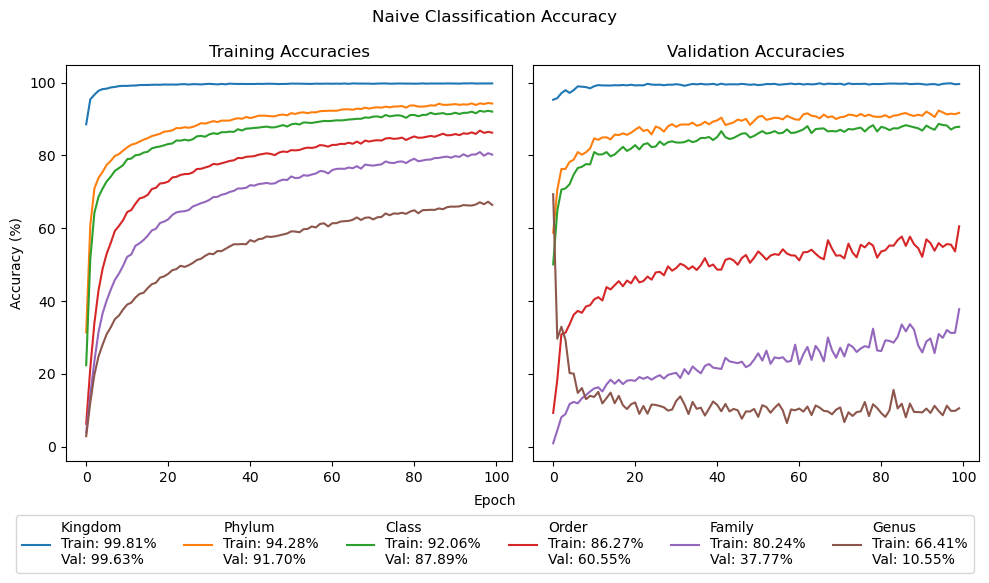

In [143]:
# plt.figure(figsize=(10, 4))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i, rank in enumerate(taxonomy.RANKS[:hierarchy.depth]):
    train_values = history_naive_unnamed.history[f"{rank.lower()}_sparse_categorical_accuracy"]
    val_values = history_naive_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.subplot(1, 2, 1)
    plt.plot(100.0*np.array(train_values), label=f"{rank}\nTrain: {train_values[-1]:.2%}\nVal: {val_values[-1]:.2%}")
    plt.subplot(1, 2, 2)
    plt.plot(100.0*np.array(val_values))
axs[0].set_title("Training Accuracies")
axs[1].set_title("Validation Accuracies")
axs[0].set_ylabel("Accuracy (%)")
handles, labels = axs[0].get_legend_handles_labels()
fig.suptitle("Naive Classification Accuracy")
fig.text(0.5, -0.01, 'Epoch', ha='center')
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.16, 0.0, 0.0), ncol=6)
plt.tight_layout()
plt.show()

---

### BERTax Unnamed

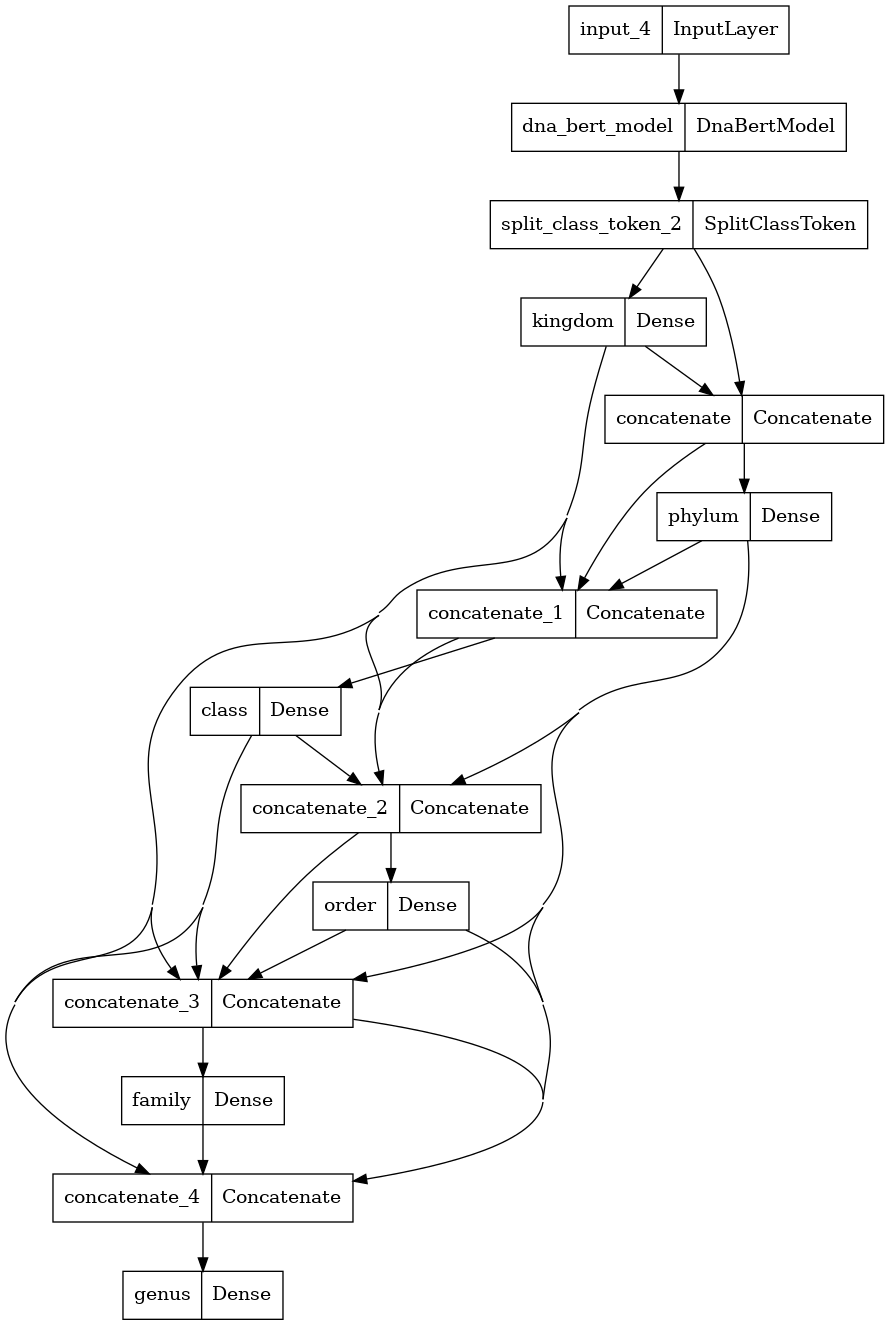

In [21]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
prev = y
out_layer = []
for i in range(hierarchy.depth):
    rank = taxonomy.RANKS[i].lower()
    out = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + 1, name=rank)(prev)
    out_layer.append(out)
    in_help = out_layer.copy()
    in_help.append(prev)
    prev = tf.keras.layers.Concatenate()(in_help)
model = tf.keras.Model(x, out_layer)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")


In [22]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 248)]        0           []                               
                                                                                                  
 dna_bert_model (DnaBertModel)  (None, 249, 128)     4751616     ['input_4[0][0]']                
                                                                                                  
 split_class_token_2 (SplitClas  ((None, 128),       0           ['dna_bert_model[2][0]']         
 sToken)                         (None, 248, 128))                                                
                                                                                                  
 kingdom (Dense)                (None, 4)            516         ['split_class_token_2[0][0]

In [23]:
history_bertax_unnamed = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

Epoch 1/100
100/100 [==============================] - 73s 687ms/step - loss: 30.6807 - kingdom_loss: 0.7921 - phylum_loss: 4.3426 - class_loss: 5.1853 - order_loss: 6.3201 - family_loss: 6.6674 - genus_loss: 7.3731 - kingdom_sparse_categorical_accuracy: 0.8560 - phylum_sparse_categorical_accuracy: 0.2830 - class_sparse_categorical_accuracy: 0.2169 - order_sparse_categorical_accuracy: 0.0900 - family_sparse_categorical_accuracy: 0.0870 - genus_sparse_categorical_accuracy: 0.0845 - val_loss: 21.0090 - val_kingdom_loss: 0.2369 - val_phylum_loss: 2.3680 - val_class_loss: 2.7991 - val_order_loss: 4.8688 - val_family_loss: 7.2706 - val_genus_loss: 3.4655 - val_kingdom_sparse_categorical_accuracy: 0.9363 - val_phylum_sparse_categorical_accuracy: 0.5674 - val_class_sparse_categorical_accuracy: 0.5142 - val_order_sparse_categorical_accuracy: 0.1433 - val_family_sparse_categorical_accuracy: 0.0303 - val_genus_sparse_categorical_accuracy: 0.2219
Epoch 2/100
100/100 [=============================

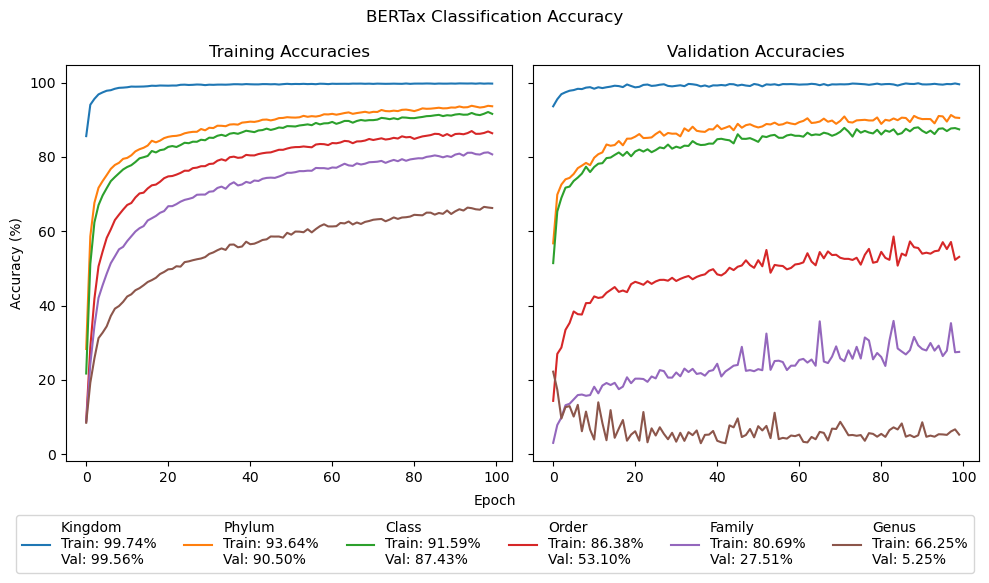

In [142]:
# plt.figure(figsize=(10, 4))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i, rank in enumerate(taxonomy.RANKS[:hierarchy.depth]):
    train_values = history_bertax_unnamed.history[f"{rank.lower()}_sparse_categorical_accuracy"]
    val_values = history_bertax_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.subplot(1, 2, 1)
    plt.plot(100.0*np.array(train_values), label=f"{rank}\nTrain: {train_values[-1]:.2%}\nVal: {val_values[-1]:.2%}")
    plt.subplot(1, 2, 2)
    plt.plot(100.0*np.array(val_values))
axs[0].set_title("Training Accuracies")
axs[1].set_title("Validation Accuracies")
axs[0].set_ylabel("Accuracy (%)")
# axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.2, 0.0, 0.0), ncol=3)
# axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, 0.0, 0.0, 0.0), ncol=3)
handles, labels = axs[0].get_legend_handles_labels()
fig.suptitle("BERTax Classification Accuracy")
fig.text(0.5, -0.01, 'Epoch', ha='center')
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.16, 0.0, 0.0), ncol=6)
plt.tight_layout()
plt.show()

---

### Ours Unnamed

In [25]:
taxon_counts_by_level = []
for i, taxons in enumerate(hierarchy.taxons[:-1]):
    taxon_counts_by_level.append([1])
    for taxon in taxons:
        taxon_counts_by_level[i].append(len(taxon.children))
taxon_counts_by_level[0]

[1, 13, 84, 106]

In [26]:
len(hierarchy.taxon_to_id_map[0])

3

In [27]:
x = tf.random.normal((1, 4))
x

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.2376092 , -0.10962155,  0.1599495 , -0.21563175]],
      dtype=float32)>

In [28]:
gate_indices = np.array([j for j, count in enumerate(taxon_counts) for _ in range(count)])
gate_indices

NameError: name 'taxon_counts' is not defined

In [ ]:
# tf.gather(x, gate_indices, axis=-1)

In [ ]:
taxon_counts_by_level[0]

In [ ]:
pretrain_model.set_weights(dnabert_weights)
y = x = tf.keras.layers.Input((pretrain_model.base.input_shape[1:]))
y = pretrain_model.base(y)
y, _ = layers.SplitClassToken()(y)
outputs = [tf.keras.layers.Dense(hierarchy.taxon_counts[0] + 1)(y)]
for i, taxon_counts in enumerate(taxon_counts_by_level, start=1):
    # Use previous output to gate the next layer
    gate_indices = [j for j, count in enumerate(taxon_counts) for _ in range(count)]
    gate = tf.gather(outputs[-1], gate_indices, axis=-1)
    gated_output = tf.keras.layers.Dense(hierarchy.taxon_counts[i] + 1)(y)
    outputs.append(tf.keras.layers.Add()([gated_output, gate]))
outputs = [tf.keras.layers.Activation("softmax", name=rank.lower())(output) for rank, output in zip(taxonomy.RANKS, outputs)]
model = tf.keras.Model(x, outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [ ]:
model.summary()

In [ ]:
history_ours_unnamed = model.fit(train_dataset, validation_data=test_dataset, epochs=100)

In [ ]:
for rank in taxonomy.RANKS[:hierarchy.depth]:
    values = history_ours_unnamed.history[f"val_{rank.lower()}_sparse_categorical_accuracy"]
    plt.plot(values, label=f"{rank} ({values[-1]:.2%})")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

---

In [38]:
from typing import TypedDict

TaxonomyOutputDict = TypedDict(
    "TaxonomyOutputDict",
    {
        "kingdom": tf.Tensor,
        "phylum": tf.Tensor,
        "class": tf.Tensor,
        "order": tf.Tensor,
        "family": tf.Tensor,
        "genus": tf.Tensor,
        "species": tf.Tensor
    },
    total=False)

class TaxonomyBlock(layers.TypedLayer[[tf.Tensor], TaxonomyOutputDict]):
    @classmethod
    def from_hierarchy(cls, hierarchy: taxonomy.TaxonomyHierarchy):
        taxon_counts_by_level = tuple(
            tuple(len(t.children) for t in taxons) for taxons in hierarchy.taxons
        )
        return cls(taxon_counts_by_level)

    def __init__(
        self,
        taxon_counts_by_level: tuple[tuple[int, ...], ...],
        include_missing: bool = True,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.taxon_counts_by_level = taxon_counts_by_level
        self.include_missing = include_missing
        self.dense_layers = [
            tf.keras.layers.Dense(len(taxon_counts) + int(self.include_missing), name=name)
            for name, taxon_counts in zip(taxonomy.RANKS, self.taxon_counts_by_level)]

    def call(self, inputs: tf.Tensor) -> dict[str, tf.Tensor]:
        """
        Outputs
        """
        prev = inputs
        out_layer = []
        for dense in self.dense_layers:
            out = dense(prev)
            out_layer.append(out)
            in_help = out_layer.copy()
            in_help.append(prev)
            prev = tf.concat(in_help, axis=1)
        # return { name.lower(): output for name, output in zip(taxonomy.RANKS, out_layer) }
        return tuple(out_layer)

    def compute_output_shape(self, input_shape):
        return tuple(
            (input_shape[:-1], len(taxon_map))
            for taxon_map in self.hierarchy.taxon_maps[:self.depth])

    def get_config(self):
        return super().get_config() | {
            "taxon_counts_by_level": self.taxon_counts_by_level
        }

class TaxonomyHierarchyBlock(layers.TypedLayer[[tf.Tensor], TaxonomyOutputDict]):
    @classmethod
    def from_hierarchy(cls, hierarchy: taxonomy.TaxonomyHierarchy):
        taxon_counts_by_level = tuple(
            tuple(len(t.children) for t in taxons) for taxons in hierarchy.taxons
        )
        return cls(taxon_counts_by_level)

    def __init__(self, taxon_counts_by_level: tuple[tuple[int, ...], ...], **kwargs):
        super().__init__(**kwargs)
        self.taxon_counts_by_level = taxon_counts_by_level
        self.dense_layers = [
            tf.keras.layers.Dense(len(taxon_counts), name=name)
            for name, taxon_counts in zip(taxonomy.RANKS, self.taxon_counts_by_level)]

    def call(self, inputs: tf.Tensor) -> dict[str, tf.Tensor]:
        """
        Outputs
        """
        outputs = [self.dense_layers[0](inputs)]
        for dense, taxon_counts in zip(self.dense_layers[1:], self.taxon_counts_by_level):
            # Use previous output to gate the next layer
            gate_indices = [0] + [j for j, count in enumerate(taxon_counts, start=1) for _ in range(count)]
            gate = tf.gather(outputs[-1], gate_indices, axis=-1)
            outputs.append(dense(inputs) + gate)
        # outputs = map(tf.nn.softmax, outputs)
        # return { name.lower(): output for name, output in zip(taxonomy.TAXON_LEVEL_NAMES, outputs) }
        return tuple(outputs)

    def compute_output_shape(self, input_shape):
        return tuple(
            (input_shape[:-1], len(taxon_map))
            for taxon_map in self.hierarchy.taxon_maps[:self.depth])

    def get_config(self):
        return super().get_config() | {
            "taxon_counts_by_level": self.taxon_counts_by_level
        }

In [39]:
y = x = tf.keras.layers.Input((16,))
y = TaxonomyBlock.from_hierarchy(hierarchy)(y)
model = tf.keras.Model(x, y)

In [49]:
def flatten_and_mask(y_true, y_pred):
    # Flatten to make computation easier
    y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
    indices = tf.where(tf.reshape(y_true, tf.shape(y_true)[:1]) != -1)
    masked_y_true = tf.gather_nd(y_true, indices)
    masked_y_pred = tf.gather_nd(y_pred, indices)
    return masked_y_true, masked_y_pred

def MaskedSparseCategoricalCrossentropy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.losses.sparse_categorical_crossentropy(masked_y_true, masked_y_pred)

def MaskedSparseCategoricalAccuracy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.metrics.sparse_categorical_accuracy(masked_y_true, masked_y_pred)

class DnaBertTaxonomyModel(tf.keras.models.Model):
    def __init__(self, base: DnaBertModel, hierarchy: taxonomy.TaxonomyHierarchy, **kwargs):
        super().__init__(**kwargs)
        self.base = base
        self.hierarchy = hierarchy
        self.hierarchy_block = TaxonomyBlock.from_hierarchy(hierarchy)
        self.model = self.build_model()

    def build_model(self):
        x = self.base.input
        y = self.base(x)
        y, _ = layers.SplitClassToken()(y)
        y = self.hierarchy_block(y)
        return tf.keras.Model(x, y)

    def call(self, inputs):
        return self.model(inputs)

    def compute_output_shpe(self, input_shape):
        return self.model.compute_output_shape(input_shape)

    def get_config(self):
        return super().get_config() | {
            "base": self.base,
            "hierarchy": self.hierarchy.serialize().decode()
        }

    @classmethod
    def from_config(cls, config):
        config["hierarchy"] = taxonomy.TaxonomyHierarchy.deserialize(config["hierarchy"])
        return super().from_config(config)

In [52]:
model = DnaBertTaxonomyModel(pretrain_model, hierarchy)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [59]:
model.fit(train_dataset)

100/100 [==============================] - 21s 210ms/step - loss: 11.6948 - output_1_loss: 1.3863 - output_2_loss: 10.3085 - output_1_sparse_categorical_accuracy: 0.0202 - output_2_sparse_categorical_accuracy: 0.0026


In [177]:
def flatten_and_mask(y_true, y_pred):
    # Flatten to make computation easier
    y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
    indices = tf.where(tf.reshape(y_true, tf.shape(y_true)[:1]) != -1)
    masked_y_true = tf.gather_nd(y_true, indices)
    masked_y_pred = tf.gather_nd(y_pred, indices)
    return masked_y_true, masked_y_pred

def MaskedSparseCategoricalCrossentropy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.losses.sparse_categorical_crossentropy(masked_y_true, masked_y_pred)

def MaskedSparseCategoricalAccuracy(y_true, y_pred):
    masked_y_true, masked_y_pred = flatten_and_mask(y_true, y_pred)
    return tf.keras.metrics.sparse_categorical_accuracy(masked_y_true, masked_y_pred)

# def taxon_accuracy(y_true, y_pred):
#     # Flatten to make computation easier
#     y_true = tf.cast(tf.reshape(y_true, (-1,)), dtype=tf.int64)
#     y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
#     correct = y_true == tf.argmax(y_pred, axis=-1)

#     # Mark masked elements as correct
#     mask_indices = tf.where(y_true == -1)
#     ones = tf.ones((tf.shape(mask_indices)[0],), dtype=tf.bool)
#     tf.tensor_scatter_nd_update(correct, mask_indices, ones)

#     return tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

In [181]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:latest").download()
pretrain_model = load_model(path)

model = DnaBertTaxonomyModel(pretrain_model.base, hierarchy)
model.model.compile(
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="kingdom_loss"),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="phylum_loss"),
    ],
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="kingdom_accuracy"),
        tf.keras.metrics.SparseCategoricalAccuracy(name="phylum_accuracy"),
    ],
    run_eagerly=False
)

wandb:   4 of 4 files downloaded.  


In [182]:
model.model(train_dataset[0][0])

(<tf.Tensor: shape=(256, 4), dtype=float32, numpy=
 array([[ 2.6379766 , -1.4894629 ,  0.3488425 ,  2.3652253 ],
        [ 0.99988204, -0.76885855, -0.45216867,  1.0107617 ],
        [ 1.1330127 ,  0.60395414,  2.3624098 , -1.3448695 ],
        ...,
        [ 1.5164968 , -0.10810965, -2.0917604 ,  0.5325261 ],
        [ 0.22892606, -1.1527599 , -2.0567613 ,  1.2639489 ],
        [ 2.414031  , -2.7477276 , -3.0217578 ,  2.7713473 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(256, 204), dtype=float32, numpy=
 array([[ 1.5850403 , -0.55561846,  1.7597157 , ...,  1.2124681 ,
         -0.06031883,  0.0791024 ],
        [ 1.7733581 , -0.9879849 ,  0.55854744, ...,  1.5324795 ,
         -0.14735456,  0.50546956],
        [ 1.9412694 , -0.465701  ,  0.0408097 , ...,  2.4299734 ,
         -0.23266722, -0.06562354],
        ...,
        [ 1.4121866 , -0.46909195,  0.53999794, ...,  1.0714287 ,
         -0.41424164,  1.5002207 ],
        [ 1.3674369 , -0.45951638, -0.66655296, ...,  0.58968514,

In [183]:
model.model.fit(train_dataset, epochs=1, validation_data=test_dataset)

100/100 [==============================] - 29s 233ms/step - loss: 6.5872 - taxonomy_block_30_loss: 2.2274 - taxonomy_block_30_1_loss: 4.3599 - taxonomy_block_30_kingdom_accuracy: 0.7167 - taxonomy_block_30_phylum_accuracy: 0.7167 - taxonomy_block_30_1_kingdom_accuracy: 0.1566 - taxonomy_block_30_1_phylum_accuracy: 0.1566 - val_loss: 4.8255 - val_taxonomy_block_30_loss: 1.2785 - val_taxonomy_block_30_1_loss: 3.5469 - val_taxonomy_block_30_kingdom_accuracy: 0.8184 - val_taxonomy_block_30_phylum_accuracy: 0.8184 - val_taxonomy_block_30_1_kingdom_accuracy: 0.1697 - val_taxonomy_block_30_1_phylum_accuracy: 0.1697


In [25]:
# model(dataset[0][0])["kingdom"]

In [26]:
model.save("./test.model")

INFO:tensorflow:Assets written to: ./test.model/assets


INFO:tensorflow:Assets written to: ./test.model/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [27]:
load_model("./test.model", custom_objects={)

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.